# Result_Fig4_3 : Salary CID with Entropy

In [1]:
# create table tt_q_tag_cnt as 
# select x.id
# 	, to_char(x.creationdate, 'yyyy-mm-dd') as c_date
# 	, (regexp_matches(x.tags, '<(ruby|scala|rust|go|bash|shell|objective-c|python|r|typescript|swift|c#|sql|assembly|kotlin|c\+\+|javascript|vba|c|html|css|java|perl|haskell|julia|php|dart|clojure|f#|elixir|erlang|lisp|groovy|crystal-lang|powershell|cobol|delphi|matlab)>', 'g'))[1] AS matched_tags
# 	, x.tag
#   from (
# 	select id, creationdate, tags, replace(replace(unnest(string_to_array(tags, '><')), '<', ''), '>', '') tag 
#   from posts
# where posttypeid ='1'
#   and (tags like '%<ruby>%' or tags like '%<scala>%' or tags like '%<rust>%' or tags like '%<go>%' or tags like '%<bash>%' or tags like '%<shell>%' or tags like '%<objective-c>%' or tags like '%<python>%' or tags like '%<r>%' or tags like '%<typescript>%' or tags like '%<swift>%' or tags like '%<c#>%' or tags like '%<sql>%' or tags like '%<assembly>%' or tags like '%<kotlin>%' or tags like '%<c++>%' or tags like '%<javascript>%' or tags like '%<vba>%' or tags like '%<c>%' or tags like '%<html>%' or tags like '%<css>%' or tags like '%<java>%' or tags like '%<perl>%' or tags like '%<haskell>%' or tags like '%<julia>%' or tags like '%<php>%' or tags like '%<dart>%' or tags like '%<clojure>%' or tags like '%<f#>%' or tags like '%<elixir>%' or tags like '%<erlang>%' or tags like '%<lisp>%' or tags like '%<groovy>%' or tags like '%<crystal-lang>%' or tags like '%<powershell>%' or tags like '%<cobol>%' or tags like '%<delphi>%' or tags like '%<matlab>%')
#   and creationdate between '2021-11-30' and '2023-12-03' 
#   ) x 
# ;

In [2]:
import sys, os
p = os.path.abspath('..')
pp = os.path.abspath('../..')

sys.path.insert(1, p)
sys.path.insert(1, pp)




In [3]:
import json
import pandas as pd
import numpy as np

from utils.salary import *
from utils.statistics import *

import config.config as conf
from constants import CONSTANTS

import psycopg2
import datetime
from statsmodels.nonparametric.smoothers_lowess import lowess
from scipy.stats import mannwhitneyu

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D




In [4]:
output_dir = './fig/'
by = 'rel_week'

In [5]:
df = pd.read_json(f'{CONSTANTS.data_availability_dir}/result/tag/salary.json') ## pd.read_json 이용

In [6]:
df = df.reset_index().rename(columns={'index':'year'})

In [7]:
df = df.sort_values(by = 'year').reset_index(drop=True)

In [8]:
df

,year,clojure,f#,elixir,erlang,perl,ruby,scala,rust,go,...,zig,apex,nim-lang,raku,ada,prolog,gdscript,vb.net,micropython,zephyr-rtos
0,2019,90000.0,80000.0,76000.0,71000.0,NaN,75000,78000,72000,80000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2020,NaN,NaN,NaN,NaN,76000.0,71000,76000,74000,74000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2021,95000.0,81037.0,80077.0,80077.0,80000.0,80000,77832,77530,75669,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2022,106644.0,95526.0,92959.0,103000.0,90073.0,93000,92780,87047,89204,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2023,96381.0,99311.0,96381.0,99492.0,94540.0,98522,96381,87012,92760,...,103611.0,81552.0,80000.0,79448.0,71500.0,70000.0,69608.0,65000.0,NaN,NaN
5,2024,95541.0,80555.0,96000.0,100636.0,90000.0,90221,88619,76292,76433,...,75332.0,82500.0,94924.0,NaN,42584.0,43327.0,60684.0,63694.0,75184.0,64444.0


In [9]:
def get_CID_ratio_rel_df(df, year) : 
    year_list = [year-3, year-2, year-1, year]
    print(year_list)
    df = df = df[df['year'].isin(year_list)]
    df_salary = df.melt(id_vars = 'year', value_vars = df.columns[1:], var_name = 'lang', value_name = 'salary')
    df_salary = df_salary.dropna()

    valid_langs = df_salary['lang'].value_counts()[lambda x: x == len(year_list)].index
    filtered_df = df_salary[df_salary['lang'].isin(valid_langs)].copy()

    filtered_df.sort_values(by=['lang', 'year'], inplace=True)
    filtered_df['growth_rate'] = filtered_df.groupby('lang')['salary'].pct_change()

    filtered_df['CID'] = filtered_df.groupby('lang')['growth_rate'].diff()
    filtered_df['CID'] = filtered_df.groupby('lang')['CID'].diff()

    filtered_df = filtered_df.dropna(subset=['growth_rate', 'CID']).reset_index(drop=True)


    return filtered_df




In [10]:
def filter_df( df, type ) :
    tot_filtered_df = pd.DataFrame()
    for year in [ 2022, 2023, 2024] : 
        filtered_df = get_CID_ratio_rel_df(df, year)    
        tot_filtered_df = pd.concat([tot_filtered_df, filtered_df], axis = 0)
    
        tot_exist_df = tot_filtered_df[tot_filtered_df['lang'].isin(tot_filtered_df['lang'].value_counts()[lambda x: x == len([ 2022, 2023, 2024])].index)].copy()
        tot_exist_df=  tot_exist_df.sort_values(by = ['year', 'CID'], ascending=[False, True])
    return tot_exist_df

In [11]:
tot_df_rl = filter_df(df, 'ratio_rel')

[2019, 2020, 2021, 2022]
[2020, 2021, 2022, 2023]
[2021, 2022, 2023, 2024]


In [12]:
cid_2024_lang = tot_df_rl[tot_df_rl['year'] == 2024].sort_values(by = ['CID'], ascending=[False])

In [13]:
cid_2024_df = tot_df_rl[tot_df_rl['lang'].isin(cid_2024_lang['lang'].values)]

In [14]:
cid_2024_df.head()
cid_2024 = cid_2024_df[cid_2024_df['year'] == 2024].sort_values(by = ['CID'], ascending=[False])

In [15]:
cid_2024.shape

(20, 5)

In [16]:
lang_t5_2024 = list(cid_2024['lang'])[:5]
lang_b5_2024 = list(cid_2024['lang'])[-5:]

In [17]:
# load data from database
q_string =  f"select c_date, matched_tags, tag, sum(prop_for_t) as cnt from tt_q_tag_cnt_02 where matched_tags in ({str([x for x in cid_2024['lang']])[1:-1]}) group by c_date, matched_tags, tag; "


In [18]:
conn = psycopg2.connect(host = conf.database_user['host'], dbname=conf.database_user['dbname'], user=conf.database_user['user'], password=conf.database_user['password'])
try:
    cur = conn.cursor()
    cur.execute(q_string)
    rows = cur.fetchall()
    

except psycopg2.DatabaseError as db_err:
    print(db_err)
finally : 
  cur.close()

In [19]:
tag_dis_df = pd.DataFrame(rows, columns = [
  'cdate' 
, 'matched_tags' 
, 'tag'
, 'cnt'
])

In [20]:
tag_dis_df.head()

,cdate,matched_tags,tag,cnt
0,2021-01-01,assembly,arm,0.50000000000000000000
1,2021-01-01,assembly,assembly,3.84999999999999999999
2,2021-01-01,assembly,c,0.78333333333333333333
3,2021-01-01,assembly,cpu-architecture,0.20000000000000000000
4,2021-01-01,assembly,cpu-registers,0.20000000000000000000


In [21]:
std_date = datetime.datetime(2022, 11, 30)

In [22]:
tag_dis_df['cdate'] = pd.to_datetime(tag_dis_df['cdate'], format="%Y-%m-%d")
tag_dis_df['rel_day'] = (tag_dis_df['cdate'] - std_date).dt.days
tag_dis_df['rel_week'] = np.floor(tag_dis_df['rel_day']/7)

In [23]:
tag_dis_df = tag_dis_df[(tag_dis_df['rel_week']>-53 ) & (tag_dis_df['rel_week']<=52 )]

In [24]:
tot_df = tag_dis_df.groupby([by, 'matched_tags'])['cnt'].sum().reset_index(name='tot_cnt')

In [25]:
tag_dis_by_df = tag_dis_df.groupby([by, 'matched_tags', 'tag'])['cnt'].sum().reset_index(name = 'cnt')

In [26]:
tag_dis_by_df.head()

,rel_week,matched_tags,tag,cnt
0,-52.0,assembly,6502,0.25000000000000000000
1,-52.0,assembly,68000,0.25000000000000000000
2,-52.0,assembly,8-bit,0.25000000000000000000
3,-52.0,assembly,8051,0.25000000000000000000
4,-52.0,assembly,addressing-mode,0.53333333333333333333


In [27]:
df_proportion = pd.merge(tag_dis_by_df, tot_df, on = [by, 'matched_tags'], how = 'left')
df_proportion['proportion'] = df_proportion['cnt'] / df_proportion['tot_cnt']

In [28]:
df_proportion['proportion'] = df_proportion['proportion'].astype(float)
df_proportion['tot_cnt'] = df_proportion['tot_cnt'].astype(float)

In [29]:
df_entropy = df_proportion.groupby([by, 'matched_tags'])['proportion'].apply(lambda x : calculate_entropy(x)).to_frame(name='entropy').reset_index()

In [30]:
df_entropy[df_entropy['matched_tags']=='python']

,rel_week,matched_tags,entropy
9,-52.0,python,4.414516
27,-51.0,python,4.461975
45,-50.0,python,4.449896
63,-49.0,python,4.456481
81,-48.0,python,4.447847
...,...,...,...
1809,48.0,python,4.916602
1827,49.0,python,4.908494
1845,50.0,python,4.956713
1863,51.0,python,4.833503


In [31]:
df_entropy_viz = pd.merge(df_entropy, df_proportion[[by, 'matched_tags', 'tot_cnt']].drop_duplicates(), \
                           on = [by, 'matched_tags'], how = 'left')

In [32]:
df_entropy_viz['log_tot_cnt'] = np.log(df_entropy_viz['tot_cnt'])

In [33]:
# lang_t5_2024.append('python')
# # lang_b5_2024.append('python')

In [34]:
df_entropy_viz_bf = df_entropy_viz[df_entropy_viz[by]<0]
df_entropy_viz_af = df_entropy_viz[df_entropy_viz[by]>=0]

In [ ]:
def analyze_entropy_change(data, measure='entropy'):
    results = []

    languages = data['matched_tags'].unique()

    for lang in languages:
        df_lang = data[data['matched_tags'] == lang]
        before = df_lang[df_lang['rel_week'] < 0]['entropy']
        after  = df_lang[df_lang['rel_week'] >= 0]['entropy']
        

        if len(before) < 5 or len(after) < 5:
            continue  

        mean_before = before.mean()
        mean_after = after.mean()
        diff = mean_after - mean_before

        pooled_se = np.sqrt(before.var(ddof=1)/len(before) + after.var(ddof=1)/len(after))
        ci_low = diff - 1.96 * pooled_se
        ci_high = diff + 1.96 * pooled_se

        pval = mannwhitneyu(before, after, alternative='two-sided').pvalue

        results.append({
            'Language': lang,
            'Mean_Before': mean_before,
            'Mean_After': mean_after,
            'Diff': diff,
            'CI_Low': ci_low,
            'CI_High': ci_high,
            'pvalue': pval
        })

    summary_df = pd.DataFrame(results)
    return summary_df

In [36]:
summary_df = analyze_entropy_change(df_entropy_viz, measure='entropy')

In [37]:
summary_df = summary_df.sort_values('Diff')
top_summary_df = summary_df[summary_df['Language'].isin(lang_t5_2024)]
bot_summary_df = summary_df[summary_df['Language'].isin(lang_b5_2024)]
mid_summary_df = summary_df[~(summary_df['Language'].isin(lang_t5_2024)) & ~(summary_df['Language'].isin(lang_b5_2024))]

In [38]:
summary_dict = dict()
summary_dict['High'] = top_summary_df
summary_dict['Mid'] = mid_summary_df
summary_dict['Low'] = bot_summary_df

In [39]:
title_dict = {'High' : 'Top5 Salary Growth Rate', 'Mid' :  'Mid Salary Growth Rate' , 'Low' :  'Bottom5 Salary Growth Rate'}

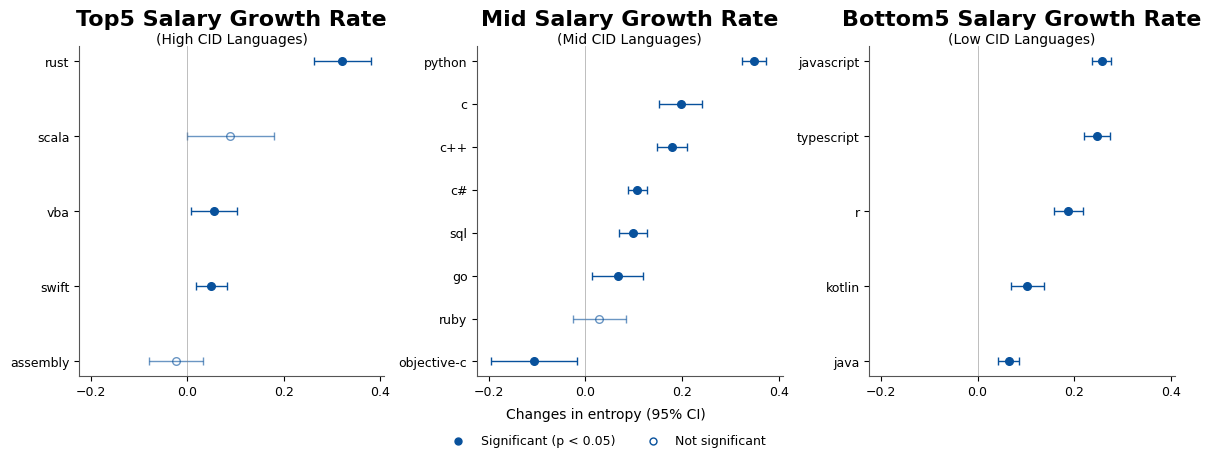

In [40]:
common_color = '#08519c'  
fig, axs = plt.subplots(1, 3, figsize=(12, 4.2), sharex=True, constrained_layout=True)

for i, key in enumerate(summary_dict.keys()):
    s_df = summary_dict[key]
    languages = s_df['Language']
    diffs = s_df['Diff'].values
    ci_lows = diffs - s_df['CI_Low'].values
    ci_highs = s_df['CI_High'].values - diffs
    p_values = s_df['pvalue'].values

    sig_mask = p_values < 0.05
    

    # 각 언어별 에러바 그리기
    for diff, ci_low, ci_high, lang, sig in zip(diffs, ci_lows, ci_highs, languages, sig_mask):
        axs[i].errorbar(
            diff, lang,
            xerr=[[ci_low], [ci_high]],
            fmt='o',
            mfc=common_color if sig else 'none',   
            mec=common_color,
            mew=1.0,
            ecolor=common_color,
            elinewidth=1.0,
            capsize=3,
            markersize=5.5,
            alpha=1.0 if sig else 0.6
        )

    axs[i].text(0.5, 1.05, f"{title_dict[key]}",
            ha='center', va='bottom', fontsize=16, fontweight='bold', transform=axs[i].transAxes)

    axs[i].text(0.5, 1.00, f"({key} CID Languages)",
            ha='center', va='bottom', fontsize=10, transform=axs[i].transAxes)   

    axs[i].axvline(0, color='gray', linestyle='-', linewidth=0.6, alpha=0.6)
    axs[i].tick_params(axis='x', labelsize=9)
    axs[i].tick_params(axis='y', labelsize=9)
    axs[i].grid(False)
    axs[i].set_xticks(np.arange(-0.2, 0.41, 0.2))


    # PNAS 스타일: 위, 오른쪽 축선 제거
    axs[i].spines['top'].set_visible(False)
    axs[i].spines['right'].set_visible(False)
    axs[i].spines['left'].set_linewidth(0.8)
    axs[i].spines['bottom'].set_linewidth(0.8)
    axs[i].spines['left'].set_color('#555555')
    axs[i].spines['bottom'].set_color('#555555')

fig.supxlabel('Changes in entropy (95% CI)', fontsize=10)

# 공통 범례 (하단 중앙)
handles = [
    plt.Line2D([], [], marker='o', color='none',
               markerfacecolor=common_color, markeredgecolor=common_color,
               markersize=5, linestyle='None', label='Significant (p < 0.05)'),
    plt.Line2D([], [], marker='o', color='none',
               markerfacecolor='none', markeredgecolor=common_color,
               markersize=5, linestyle='None', label='Not significant')
]

fig.legend(
    handles=handles,
    loc='lower center',
    bbox_to_anchor=(0.5, -0.08),
    ncol=2,
    frameon=False,
    fontsize=9
)
plt.savefig(f"{output_dir}C_Result_Fig4_3.png", dpi=300, bbox_inches='tight')
plt.show()
